# Capstone Week 3
---

# Index
- [Capstone Objectives](#Capstone-Objectives)
- [Read in Data](#Read-in-Data)
    - [Merge 2018 and 2019](#Merge-2018-and-2019)
    - [Make advisor dictionary mapper](#Make-advisor-dictionary-mapper)
- [Data Cleaning](#Data-Cleaning)
    - [Train-Test-Split](#Train-Test-Split)
    - [Custom Cleaning Functions](#Custom-Cleaning-Functions)
    - [Create Cleaning Pipeline](#Create-Cleaning-Pipeline)
- [Model building](#Model-building)
- [Make predictions](#Make-predictions)
- [Feature Engineering](#Feature-Engineering)
    - [Variable Inflation Factor (VIF)](#Variable-Inflation-Factor-(VIF))
- [Residuals](#Residuals)
- [Classification](#Classification)
- [Model Interpretation](#Model-Interpretation)

# Capstone Objectives
- Assist sales and marketing by improving their targeting
- Predict sales for 2019 using the data for 2018
- Estimate the probability of adding a new fund in 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

pd.set_option('display.max_columns', 50)

[Back to Top](#Index)
# Read in Data

In [2]:
df18 = pd.read_excel("../Transaction Data.xlsx", sheet_name='Transactions18')
df19 = pd.read_excel("../Transaction Data.xlsx", sheet_name='Transactions19')
firms = pd.read_excel("../Firm Information.xlsx", header=1)

## Merge 2018 and 2019

In [3]:
df = pd.merge(
    df18,
    df19,
    on='CONTACT_ID',
    suffixes=['_2018', '_2019']
)
df.head()

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_2018,sales_12M_2019,new_Fund_added_12M_2019,refresh_date_2019
0,0047433,21.0,38.0,NaN,1.0,5.0,5.0,NaN,1.0,2.0,2.0,NaN,1.0,8.0,1.0,237480.11,250.0,19682.0,-1496.745,-102496.165,NaN,-47342.32,284737.93,84.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122866.04,114614.07,0.0,0.0,2018-12-31,18633.105,NaN,2019-12-31
1,4461312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,19629.00,NaN,NaN,NaN,NaN,NaN,0.00,19629.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19629.00,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31
2,4491079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1758.70,NaN,NaN,NaN,NaN,NaN,0.00,1758.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31
3,0107408,20.0,NaN,2.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,57943.00,5459.0,52484.0,NaN,NaN,1.0,0.00,0.00,57943.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57943.00,0.00,0.0,0.0,2018-12-31,93212.000,1.0,2019-12-31
4,85101140503769936458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8573.59,NaN,NaN,NaN,NaN,NaN,-8573.59,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8573.59,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31


## Make advisor dictionary mapper

In [4]:
adviser_lookup = {
    idx: contact_id 
        for idx, contact_id in enumerate(df['CONTACT_ID'])
}

In [5]:
adviser_lookup[10]

'85102150753418532658'

[Back to Top](#EDA)
# EDA

In [8]:
# !conda install -yc conda-forge pandas-profiling

In [9]:
# from pandas_profiling import ProfileReport

# missing_diagrams = {
#     'heatmap': True, 'dendrogram': True, 'matrix':True, 'bar': True,
# }

# profile = ProfileReport(df, title='Nuveen Profile Report', missing_diagrams=missing_diagrams)

# profile.to_file(output_file="nuveen_profiling.html")

[Back to Top](#Index)
# Data Cleaning

In [6]:
# make a variable to keep all of the columns we want to drop
COLS_TO_DROP = [
    'refresh_date_2019', 'refresh_date_2018', 'CONTACT_ID',
]

COLS_TO_KEEP = [
    'no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'no_of_sales_12M_10K',
    'no_of_Redemption_12M_10K', 'no_of_funds_sold_12M_1',
    'no_of_funds_redeemed_12M_1', 'no_of_fund_sales_12M_10K',
    'no_of_funds_Redemption_12M_10K', 'no_of_assetclass_sold_12M_1',
    'no_of_assetclass_redeemed_12M_1', 'no_of_assetclass_sales_12M_10K',
    'no_of_assetclass_Redemption_12M_10K', 'No_of_fund_curr',
    'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_2018',
    'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_2018',
    'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
    'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
    'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
    'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
    'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT',
]

In [7]:
X = df.drop(['sales_12M_2019', 'new_Fund_added_12M_2019'], axis=1)
y_reg = df['sales_12M_2019']
y_cl = df['new_Fund_added_12M_2019']

## Train-Test-Split

In [14]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=24
)
y_train_cl, y_test_cl = y_cl[y_train_reg.index], y_cl[y_test_reg.index]

## Custom Cleaning Functions

Let's create functions that do some basic housekeeping

In [15]:
def extract_columns(df):
    '''extract out columns not listed in COLS_TO_DROP variable'''
    cols_to_keep = [col for col in df.columns if col not in COLS_TO_DROP]
    return df.loc[:, cols_to_keep].copy()


def fillna_values(df):
    '''fill nan values with zero'''
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.fillna(0)
    num_df = df.select_dtypes(include=['number']).fillna(0)
    non_num_df = df.select_dtypes(exclude=['number'])
    return pd.concat([num_df, non_num_df], axis=1)


def negative_to_zero(df):
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.apply(lambda x: max(0, x))
    else:
        return df.select_dtypes(include='number').clip(lower=0)

[Back to Top](#Index)
## Create Cleaning Pipeline

- Pipeline for target variable
- Pipeline for features

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.preprocessing import StandardScaler

In [17]:
extract_columns_trans = FunctionTransformer(extract_columns)
fillna_values_trans = FunctionTransformer(fillna_values)
negative_to_zero_trans = FunctionTransformer(negative_to_zero)

Make pipeline for regression target variable

In [36]:
targ_pipe_reg = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('negative_to_zero_trans', negative_to_zero_trans),
    ('PowerTransformer', PowerTransformer(standardize=False))
])

y_train_reg = pd.Series(
    targ_pipe_reg.fit_transform(y_train_reg.to_frame()).squeeze(),
    index=y_train_reg.index
)
y_test_reg = pd.Series(
    targ_pipe_reg.transform(y_test_reg.to_frame()).squeeze(),
    index=y_test_reg.index
)

<AxesSubplot:>

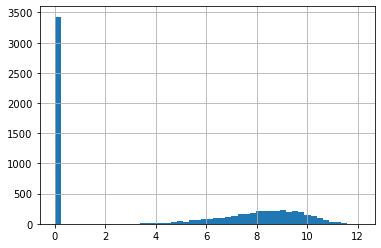

In [37]:
y_train_reg.hist(bins=50)

Transform the classification target

In [38]:
from sklearn.preprocessing import Binarizer

targ_pipe_cl = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('Binarizer', Binarizer(threshold=0))
])

y_train_cl = pd.Series(
    targ_pipe_cl
        .fit_transform(y_train_cl.to_frame())
        .reshape(-1), index=y_train_cl.index)

y_test_cl = pd.Series(
    targ_pipe_cl
        .transform(y_test_cl.to_frame())
        .reshape(-1), index=y_test_cl.index)
y_test_cl

2052    0.0
2758    1.0
4334    0.0
9047    1.0
7001    0.0
       ... 
3541    1.0
785     0.0
7614    0.0
9577    0.0
1086    0.0
Length: 3002, dtype: float64

Create the pipeline for the features

In [39]:
feat_pipe = Pipeline([
    ('extract_columns_trans', extract_columns_trans),
    ('fillna_values_trans', fillna_values_trans),
    ('StandardScaler', StandardScaler()),
])

X_train_prepared = feat_pipe.fit(X_train).transform(X_train)
X_test_prepared = feat_pipe.transform(X_test)

**TRANSFORM** Test set

In [40]:
X_train_prepared = pd.DataFrame(
    X_train_prepared,
    index=X_train.index,
    columns=COLS_TO_KEEP
)

X_test_prepared = pd.DataFrame(
    feat_pipe.transform(X_test),
    index=X_test.index,
    columns=COLS_TO_KEEP
)

In [41]:
X_test_prepared

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT
2052,-0.199371,-0.093252,-0.207843,-0.089515,-0.573977,-0.221485,-0.430359,0.301512,-0.784078,0.083188,-0.536570,0.782602,-0.373415,0.063655,-0.258339,-0.085083,-0.151783,-0.609095,0.095688,-0.415778,-0.518275,-0.078960,-0.058282,-0.012892,-0.022410,6.269968,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.259043,-0.056194,-0.01714,-0.070413
2758,-0.159635,-0.048462,-0.207843,-0.205862,-0.153081,0.591014,-0.430359,-0.442232,0.201190,1.035094,-0.536570,-0.561332,-0.693256,-0.888855,-0.102691,-0.083568,-0.151026,0.091395,0.146089,-0.415778,-0.039400,-0.078960,-0.065878,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.073601,-0.056194,-0.01714,-0.070413
4334,-0.199371,-0.097731,-0.207843,-0.205862,-0.573977,-0.627735,-0.430359,-0.442232,-0.784078,-0.868718,-0.536570,-0.561332,-0.373415,0.063655,-0.093857,-0.085083,-0.151783,0.091395,0.155620,-0.415778,-0.027182,-0.079302,-0.040421,-0.012892,-0.018591,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.063076,-0.056194,-0.01714,-0.070413
9047,0.118515,0.050076,-0.207843,-0.205862,0.688712,0.591014,-0.430359,-0.442232,1.186457,1.035094,-0.536570,-0.561332,-0.053573,0.063655,-0.096939,-0.073236,-0.133039,0.091103,0.144632,-0.415778,-0.014956,-0.085461,-0.058935,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.066749,-0.056194,-0.01714,-0.070413
7001,0.009242,0.171009,-0.115750,0.259524,-0.153081,1.403513,0.318971,1.789002,0.201190,1.035094,0.858232,2.126536,0.266268,0.063655,-0.098609,-0.085083,-0.077280,0.070873,-0.189406,-0.415778,-0.037940,-0.079761,-0.037229,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.068738,-0.056194,-0.01714,-0.070413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3541,0.376797,0.112782,1.357732,0.375870,1.109608,0.591014,1.817630,1.789002,2.171725,1.987000,3.647837,3.470469,0.905951,1.016164,0.240511,-0.085083,0.168188,-0.352809,-0.123876,1.289958,-0.098124,-0.029076,-0.138181,-0.012892,4.647680,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,0.335295,-0.056194,-0.01714,-0.070413
785,-0.199371,-0.097731,-0.207843,-0.205862,-0.573977,-0.627735,-0.430359,-0.442232,-0.784078,-0.868718,-0.536570,-0.561332,-0.693256,-0.888855,-0.097262,-0.085083,-0.151783,0.091395,0.155620,-0.415778,-0.029158,-0.078960,-0.058282,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.067133,-0.056194,-0.01714,-0.070413
7614,-0.199371,-0.097731,-0.207843,-0.205862,-0.573977,-0.627735,-0.430359,-0.442232,-0.784078,-0.868718,-0.536570,-0.561332,-0.373415,0.063655,-0.085369,-0.085083,-0.151783,0.091395,0.155620,-0.415778,-0.029158,-0.065118,-0.058282,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.052964,-0.056194,-0.01714,-0.070413
9577,-0.000692,-0.084294,-0.115750,-0.205862,0.688712,-0.221485,0.318971,-0.442232,1.186457,0.083188,0.858232,-0.561332,0.266268,1.016164,-0.065484,-0.079434,-0.123801,0.091395,0.155591,-0.415778,0.018326,-0.065245,-0.058282,-0.012892,-0.023818,-0.038570,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.040609,-0.037756,-

[Back to Top](#Index)
# Model building
- Evaluate baseline model
- Create new models
- Create evaluation function and cross validate

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA, TruncatedSVD
import xgboost as xgb

In [43]:
lr = LinearRegression()
lr.fit(X_train_prepared, y_train_reg)

LinearRegression()

In [44]:
from sklearn.model_selection import cross_validate

In [45]:
-cross_validate(
    lr, 
    X_train_prepared, 
    y_train_reg, 
    cv=3, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
)['test_score']

array([3.32515627e+00, 2.45976350e+10, 3.33027277e+00])

Make a plot of predictions vs actual

In [46]:
y_test_reg_preds = lr.predict(X_test_prepared)

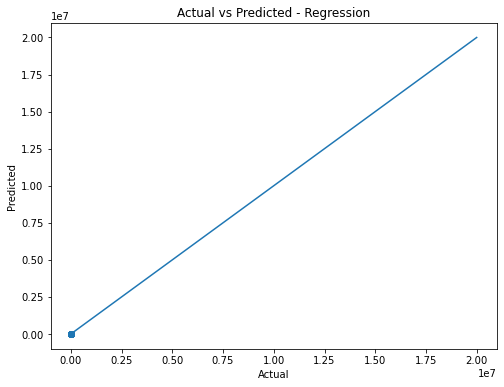

In [47]:
fig, axes = plt.subplots(figsize=(8, 6))

axes.scatter(x=y_test_reg, y=y_test_reg_preds)

axes.plot([0, 20000000], [0,20000000])
axes.set_title("Actual vs Predicted - Regression")
axes.set_xlabel("Actual")
axes.set_ylabel("Predicted");

In [48]:
def evaluate_model(model, X, y):
    print("Cross Validation Scores:")
    print(-cross_validate(model, X, y, scoring='neg_root_mean_squared_error')['test_score'])
    print('-'*55)
    preds = model.predict(X)
    lim = max(preds.max(), y.max())
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.scatter(x=y, y=preds, alpha=0.4)
    ax.plot([0, lim], [0, lim])
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])
    ax.set_title("Actual vs Predicted - Regression")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted");

Cross Validation Scores:
[ 3.20041514  3.20295751  3.4357037   3.31322157 18.41327458]
-------------------------------------------------------


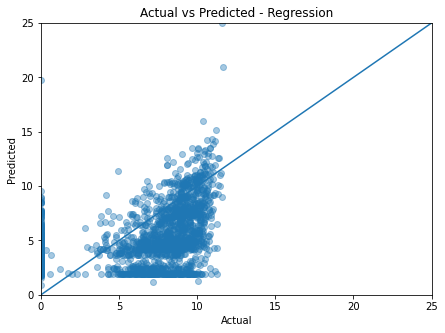

In [49]:
evaluate_model(lr, X_test_prepared, y_test_reg)

[Back to Top]
## Residual Analysis

In [50]:
y_test_reg_preds = lr.predict(X_test_prepared)

In [51]:
# get the residuals
residuals = y_test_reg_preds - y_test_reg

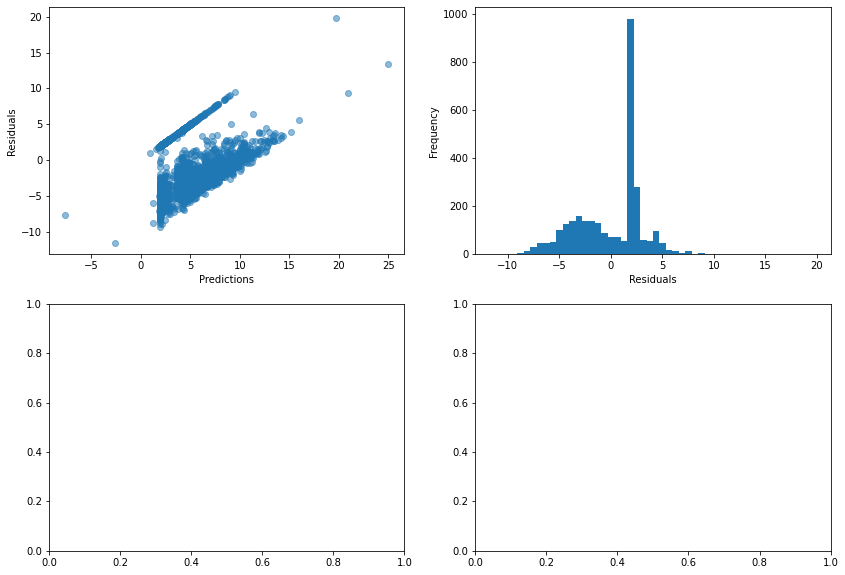

In [64]:
# plot predictions vs residuals
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

# plot scatter plot on upper left plot
axes[0,0].scatter(x=y_test_reg_preds, y=residuals, alpha=0.5)
axes[0,0].set(xlabel='Predictions', ylabel='Residuals')

# plot a hist on upper right plot
axes[0,1].hist(residuals, bins=50)
axes[0,1].set(xlabel='Residuals', ylabel='Frequency');

In [63]:
from statsmodels.api import qqplot

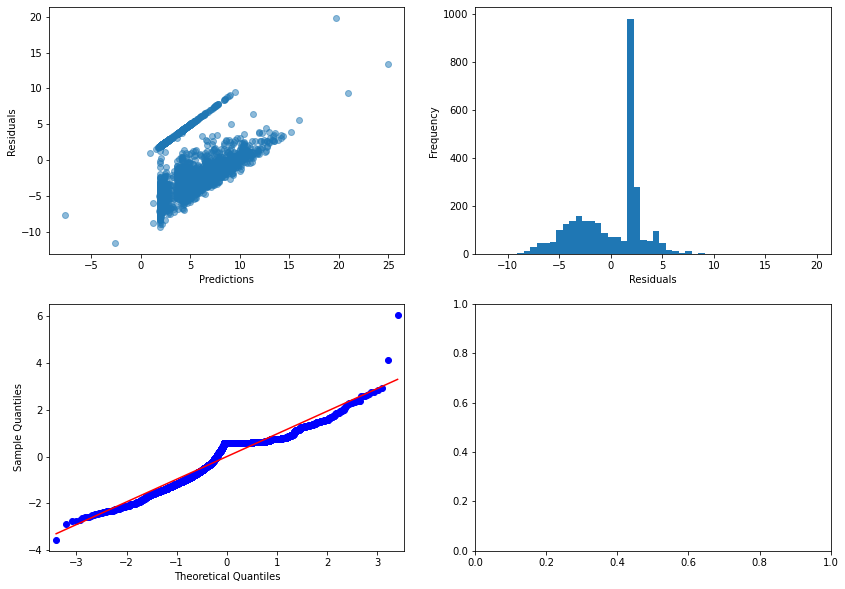

In [65]:
qqplot(residuals, fit=True, line='r', ax=axes[1,0])

In [66]:
y_test_reg_preds

array([2.16753409, 4.67150138, 2.02458976, ..., 2.02571891, 6.66686271,
       4.89807532])

In [74]:
targ_pipe_reg.named_steps['PowerTransformer'].inverse_transform(y_test_reg_preds.reshape(-1,1)).squeeze()

array([   8.82165095,  192.67834425,    7.38315036, ...,    7.39360573,
       2916.61811174,  258.18272438])

In [ ]:
# !pip install scikit-plot

In [75]:
import scikitplot as skplt

In [ ]:
def evaluate_classifier(X, y, model):
    # print classification report
    # create lift charts
    # create gains charts

In [76]:
from sklearn.ensemble import RandomForestClassifier

In [77]:
rf = RandomForestClassifier()

In [78]:
rf.fit(X_train_prepared, y_train_cl)

RandomForestClassifier()

In [80]:
y_test_cl_preds = rf.predict_proba(X_test_prepared)

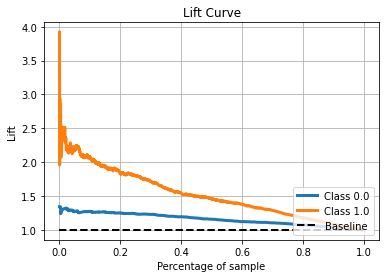

In [85]:
skplt.metrics.plot_lift_curve(y_test_cl, y_test_cl_preds);

In [88]:
np.sort(y_test_cl_preds)[:10]

array([[0.25, 0.75],
       [0.28, 0.72],
       [0.19, 0.81],
       [0.31, 0.69],
       [0.32, 0.68],
       [0.04, 0.96],
       [0.41, 0.59],
       [0.18, 0.82],
       [0.1 , 0.9 ],
       [0.01, 0.99]])